In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
base_dir = '/kaggle/input/small-dataset-glrv/small_dataset_glrv2'

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

**Data preprocessing**

In [4]:
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')

BATCH_SIZE = 32
IMG_SIZE = (160,160)

train_dataset = image_dataset_from_directory(train_dir,
                                            shuffle= True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)

Found 14543 files belonging to 10 classes.


In [5]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                            shuffle= True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)

Found 3636 files belonging to 10 classes.


In [6]:
class_names = train_dataset.class_names

In [7]:
class_names

['113209',
 '126637',
 '138982',
 '139894',
 '149980',
 '177870',
 '1924',
 '194914',
 '20409',
 '83144']

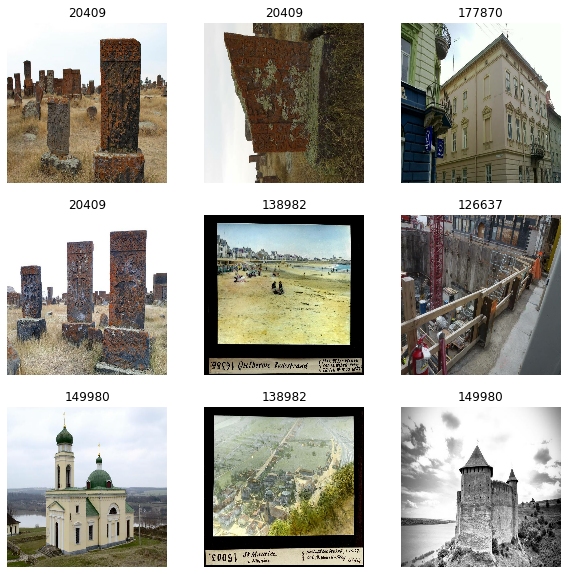

In [8]:
plt.figure(figsize=(10,10))
for images,labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('Off')

In [9]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [10]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 92
Number of test batches: 22


In [11]:

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [12]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

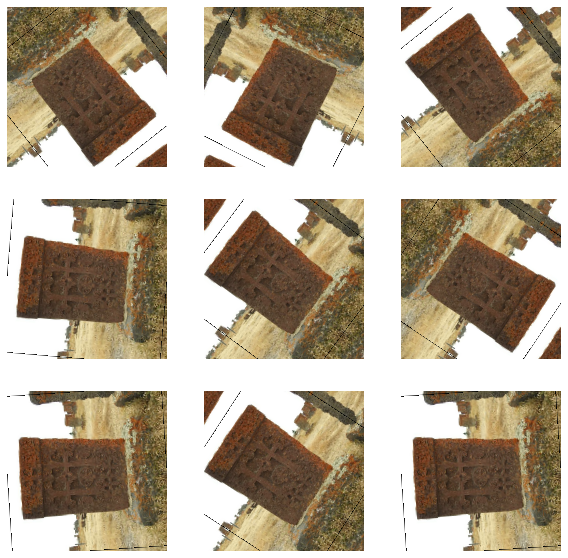

In [13]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10,10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image,0))
        plt.imshow(augmented_image[0]/255)
        plt.axis('Off')

In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1/127.5, offset = -1)

<font size = 5>**Transfer Learning using Imagenet weights on MobileNetV2 architecture**</font>

In [15]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape= IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [16]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [17]:
image_batch,label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [18]:
base_model.trainable = False

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [20]:
prediction_layer = tf.keras.layers.Dense(len(class_names))
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


In [21]:
inputs = tf.keras.Input(shape=(160,160,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x,training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs,outputs)

In [22]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr= base_learning_rate),
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
             metrics=['accuracy'])

In [23]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [24]:
len(model.trainable_variables)

2

In [25]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

92/92 [==============================] - 12s 136ms/step - loss: 2.5859 - accuracy: 0.0744


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.59
initial accuracy: 0.07


In [27]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
455/455 [==============================] - 79s 174ms/step - loss: 1.3474 - accuracy: 0.5664 - val_loss: 0.9608 - val_accuracy: 0.7254
Epoch 2/10
455/455 [==============================] - 55s 121ms/step - loss: 0.6785 - accuracy: 0.7825 - val_loss: 0.6781 - val_accuracy: 0.8097
Epoch 3/10
455/455 [==============================] - 55s 120ms/step - loss: 0.5273 - accuracy: 0.8286 - val_loss: 0.5591 - val_accuracy: 0.8411
Epoch 4/10
455/455 [==============================] - 55s 121ms/step - loss: 0.4588 - accuracy: 0.8524 - val_loss: 0.4838 - val_accuracy: 0.8643
Epoch 5/10
455/455 [==============================] - 54s 119ms/step - loss: 0.4063 - accuracy: 0.8700 - val_loss: 0.4298 - val_accuracy: 0.8745
Epoch 6/10
455/455 [==============================] - 54s 119ms/step - loss: 0.3705 - accuracy: 0.8811 - val_loss: 0.3953 - val_accuracy: 0.8885
Epoch 7/10
455/455 [==============================] - 54s 118ms/step - loss: 0.3569 - accuracy: 0.8865 - val_loss: 0.3715 - val_ac

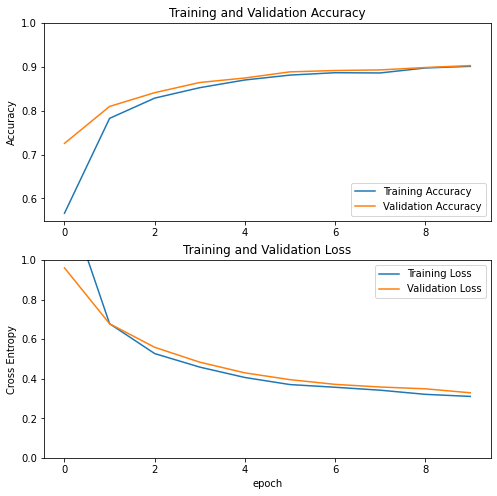

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [29]:
base_model.trainable = True

In [30]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False


Number of layers in the base model:  155


In [31]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [32]:
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [33]:
len(model.trainable_variables)


58

In [34]:
fine_tune_epochs = 25
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 10/35
455/455 [==============================] - 56s 123ms/step - loss: 0.2865 - accuracy: 0.9053 - val_loss: 0.2718 - val_accuracy: 0.9181
Epoch 11/35
455/455 [==============================] - 55s 121ms/step - loss: 0.2323 - accuracy: 0.9222 - val_loss: 0.2263 - val_accuracy: 0.9291
Epoch 12/35
455/455 [==============================] - 55s 121ms/step - loss: 0.1974 - accuracy: 0.9356 - val_loss: 0.2007 - val_accuracy: 0.9403
Epoch 13/35
455/455 [==============================] - 55s 120ms/step - loss: 0.1803 - accuracy: 0.9402 - val_loss: 0.1834 - val_accuracy: 0.9434
Epoch 14/35
455/455 [==============================] - 54s 119ms/step - loss: 0.1553 - accuracy: 0.9502 - val_loss: 0.1652 - val_accuracy: 0.9465
Epoch 15/35
455/455 [==============================] - 54s 120ms/step - loss: 0.1409 - accuracy: 0.9530 - val_loss: 0.1770 - val_accuracy: 0.9454
Epoch 16/35
455/455 [==============================] - 55s 120ms/step - loss: 0.1302 - accuracy: 0.9558 - val_loss: 0.1638 -

In [35]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

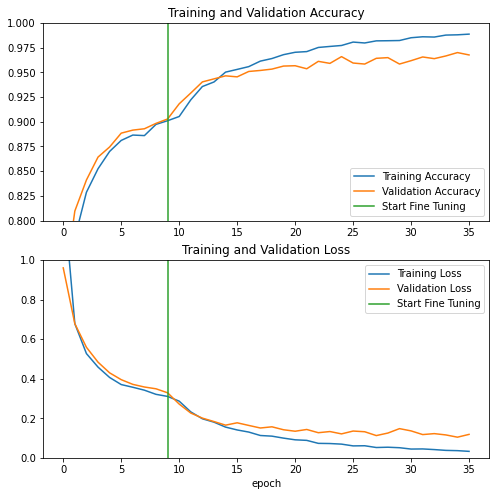

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [37]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

22/22 [==============================] - 2s 89ms/step - loss: 0.1231 - accuracy: 0.9531
Test accuracy : 0.953125


Predictions:
 [4 1 5 3 3 5 9 3 2 1 0 9 8 1 8 2 8 5 6 1 3 9 6 2 4 6 8 2 8 9 2 7]
Labels:
 [4 1 5 3 3 2 9 3 2 1 0 9 8 1 8 2 8 5 6 1 3 9 6 2 4 6 8 2 8 9 2 7]


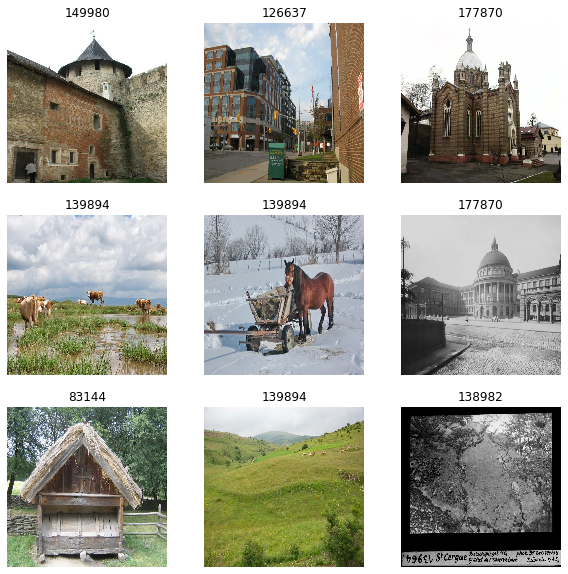

In [53]:

image_batch,label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = tf.nn.softmax(predictions)
print('Predictions:\n', np.argmax(predictions.numpy(),axis=1))
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[np.argmax(predictions[i])])
    plt.axis("off")